# Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).

Your project is to:

1. Predict conversion rate

2. Come up with recommendations for the product team and the marketing team to
improve conversion rate

## 1. Load Data 

In [1]:
import pandas as pd
df = pd.read_csv(".data/conversion_data.csv")

In [2]:
# quick glimpse
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.shape

(316200, 6)

In [4]:
# check missing value and data type
pd.concat([df.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          df.apply(lambda x: len(x.unique())).rename("num_unique")], axis=1)

,num_missing,num_unique
country,0,4
age,0,60
new_user,0,2
source,0,3
total_pages_visited,0,29
converted,0,2


## 2. Exploratory  

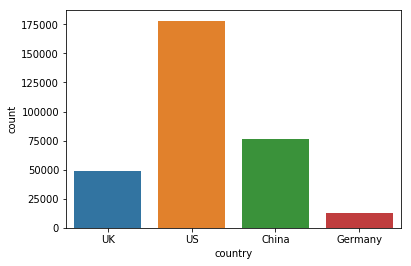

In [5]:
# check feature distribution
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
sns.countplot(df.country)

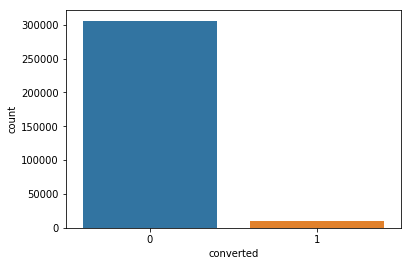

In [8]:
sns.countplot(df.converted)

In [9]:
sum(df.converted == 1)/len(df)

0.03225806451612903

### Note: Use converted as label, the data is severly imbalanced should consider under/oversampling or adjust weight

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


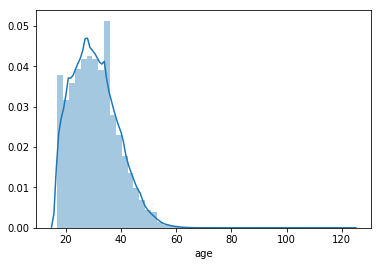

In [10]:
sns.distplot(df.age)

In [11]:
# filter out the following outliers
df[df.age>80]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [12]:
df = df[df.age<=80]

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


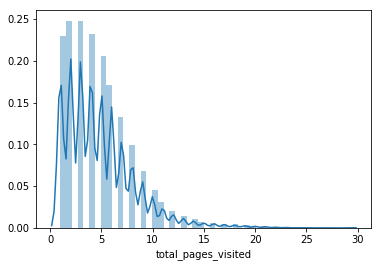

In [13]:
sns.distplot(df.total_pages_visited)

## 3. Modeling 

In [14]:
df = pd.get_dummies(df, ['country', 'source'])
df.shape

(316198, 11)

In [15]:
from sklearn.model_selection import train_test_split

y = df.converted
X = df.drop(['converted'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=233)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((252958, 10), (63240, 10), (252958,), (63240,))

In [24]:
# handle data imbalance with SMOTE, did not undersample because of large test size

from imblearn.over_sampling import SMOTE
import numpy as np 

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(X_train_smote.shape)
print(np.bincount(y_train_smote))

(489598, 10)
[244799 244799]


In [37]:
# model 1 logistic regression

from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

smote_pipe = make_pipeline(SMOTE(), LogisticRegression(solver='liblinear'))
scores = cross_validate(smote_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.984618251353021, 0.8356859935195978)

In [39]:
# model 2 random forest

smote_pipe_rf = make_pipeline(SMOTE(), RandomForestClassifier(n_estimators=128))
scores_rf = cross_validate(smote_pipe_rf, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores_rf['test_roc_auc'].mean(), scores_rf['test_average_precision'].mean()

(0.9499841867173495, 0.7322180227979695)

Weirdly, with an rf the behavior didn't improve due to too many imbalance data I guess. So at this step we choose model 1 as our current best model to predict whether a user would convert or not. 

The total_pages_visited is confusing. It's still an useful indicator with some risk of colinearity. 

In [49]:
# model 3 without smote, use rf's default balanced weight

rf = RandomForestClassifier(random_state= 123, n_estimators=512, class_weight="balanced")
scores = cross_validate(rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9497828673465853, 0.7507955888483593)

In [42]:
# evaluate on test data

smote_pipe.fit(X_train, y_train)
smote_pipe.score(X_test, y_test)

0.9519607843137254

In [51]:
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9581752055660974

In [43]:
# model report for logistic regression

from sklearn.metrics import classification_report
print(classification_report(y_test, smote_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     61201
           1       0.40      0.92      0.55      2039

   micro avg       0.95      0.95      0.95     63240
   macro avg       0.70      0.94      0.76     63240
weighted avg       0.98      0.95      0.96     63240



In [52]:
# model report for rf

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     61201
           1       0.42      0.84      0.56      2039

   micro avg       0.96      0.96      0.96     63240
   macro avg       0.71      0.90      0.77     63240
weighted avg       0.98      0.96      0.96     63240



In [55]:
X_train.columns

Index(['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo'],
      dtype='object')

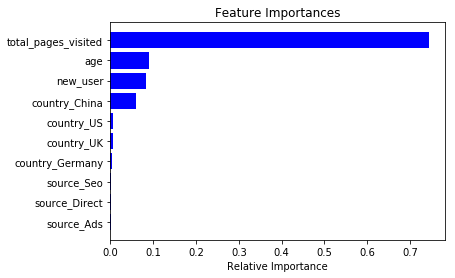

In [56]:
# plot rf feature importance 

features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [74]:
# change data without total_pages_visited; adjust class weight

X_train_2 = X_train.drop(['total_pages_visited'], axis=1)
X_test_2 = X_test.drop(['total_pages_visited'], axis=1)

### Using naive gbc, which is maybe the only one model supports partial dependence plot in Python

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_2, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [73]:
gbc.score(X_test_2,y_test)

0.9677577482605946

### It's an acceptable result without risk of colinearity with only 100 default estimators.

## 4. Insights

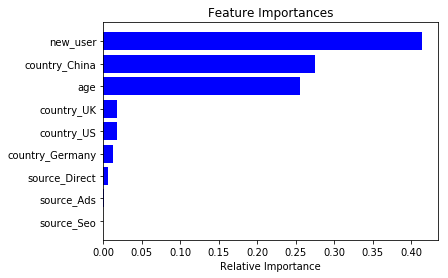

In [75]:
# new importance

features = X_train_2.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [65]:
# sadly partial_dependence only supports boosting in Python
# https://github.com/scikit-learn/scikit-learn/issues/4405

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [87]:
X_train_2.columns

Index(['age', 'new_user', 'country_China', 'country_Germany', 'country_UK',
       'country_US', 'source_Ads', 'source_Direct', 'source_Seo'],
      dtype='object')

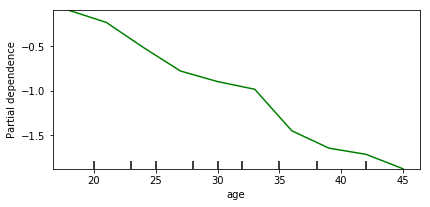

In [89]:
# Here we make the plot
my_plots = plot_partial_dependence(gbc,       
                                   features=[0], # column numbers of plots we want to show
                                   X=X_train_2,            # raw predictors data.
                                   feature_names=X_train_2.columns, # labels on graphs
                                   grid_resolution=10)

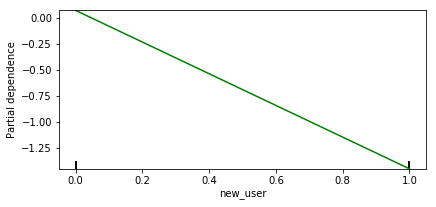

In [90]:
my_plots = plot_partial_dependence(gbc,       
                                   features=[1], # column numbers of plots we want to show
                                   X=X_train_2,            # raw predictors data.
                                   feature_names=X_train_2.columns, # labels on graphs
                                   grid_resolution=10)

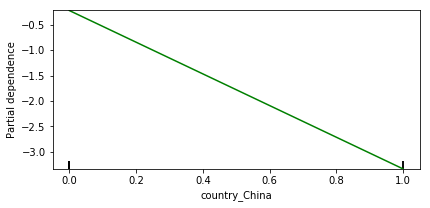

In [96]:
my_plots = plot_partial_dependence(gbc,       
                                   features=[2], # column numbers of plots we want to show
                                   X=X_train_2,            # raw predictors data.
                                   feature_names=X_train_2.columns, # labels on graphs
                                   grid_resolution=10)

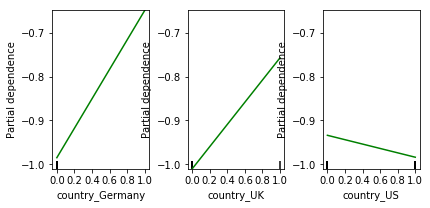

In [98]:
my_plots = plot_partial_dependence(gbc,       
                                   features=range(3,6), # column numbers of plots we want to show
                                   X=X_train_2,            # raw predictors data.
                                   feature_names=X_train_2.columns, # labels on graphs
                                   grid_resolution=10)

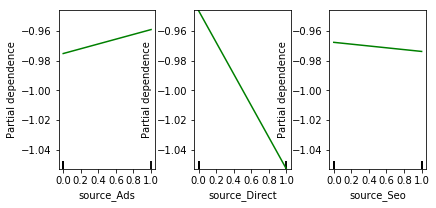

In [100]:
my_plots = plot_partial_dependence(gbc,       
                                   features=range(6,9), # column numbers of plots we want to show
                                   X=X_train_2,            # raw predictors data.
                                   feature_names=X_train_2.columns, # labels on graphs
                                   grid_resolution=10)

#### Takeaways:

1. Old users better than new users.

2. Something wrong with China's marketing strategy.

3. Young users better than old users.

4. Direct source is not good. Ads source is slightly helpful to improve conversion rate.

5. Explore the market in German.

# TODO: visualize decision tree to see possible segmentation